# Week 2 Problem 1

If you are not using the `Assignments` tab on the course JupyterHub server to read this notebook, read [Activating the assignments tab](https://github.com/lcdm-uiuc/info490-sp17/blob/master/help/act_assign_tab.md).

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do **not** write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select _Kernel_, and restart the kernel and run all cells (_Restart & Run all_).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select _File_  → _Save and CheckPoint_)

5. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

# Multivariate Regression

In this problem, we will first use seaborn to fit a linear regression model that predicts `Distance` from `AirTime`. Next, we will split the data set into a training set and a test. Then, we will use the training set to fit a multivariate regression model that predicts `Distance` from `AirTime` and `ArrDelay`. Finally, we will evaulate the performance of our model on the test set.

This notebook is quite long but this is primarily because of documentation and unit tests. The amount of code you actually have to write in terms of lines of code is not that much.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state

import statsmodels.api as sm
import statsmodels.formula.api as smf

from nose.tools import assert_equal, assert_is_not, assert_in
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal

sns.set(style="white", font_scale=2.0)

We will use the same [airline on-time performance data](http://stat-computing.org/dataexpo/2009/) from the previous semester. You can find the descriptions [here](http://stat-computing.org/dataexpo/2009/). For simplicity, we drop all missing values and limit our analysis to flights that departed from O'Hare.

In [2]:
filename = '/home/data_scientist/data/2001.csv'

usecols = (13, 14, 16, 18)
columns = ['AirTime', 'ArrDelay', 'Origin', 'Distance']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data.loc[all_data['Origin'] == 'ORD'].dropna()

## Use Seaborn to plot a linear regression model

Let's start by plotting a scatter plot of `AirTime` vs. `Distance` and fitting a linear regression model.

- Use [seaborn.regplot](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.regplot.html) to write a function named `plot_seaborn_reg()` that creates a scatter plot with `AirTime` in the $x$-axis and `Distance` in the $y$-axis. The function shuold also fit a linear regression model in the same plot. Note that the function should return an instance of [matplotlib Axes](http://matplotlib.org/users/artists.html) object.

In [3]:
def plot_seaborn_reg(df):
    '''
    Uses Seaborn to create a scatter plot of "AirTime" vs "Distance" columns in "df".
    Also fits a linear regression model in the same plot.
    
    Parameters
    ----------
    df: A pandas.DataFrame. Should have columns named "AirTime" and "Distance".
    
    Returns
    -------
    A matplotlib
    '''
    #####################
    plotdata = pd.DataFrame(data = df, columns = ["AirTime", "Distance"])
    
    # create a scatter plot and fit a linear regression model
    ax = sns.regplot(data = plotdata, x='AirTime', y='Distance')
    
    # set title
    ax.set(title='Seaborn linear regression',
       xlabel='AirTime (min)', xlim=(-100, 700),
       ylabel='Distance (miles)', ylim=(-2000, 6000))

    sns.despine(offset=0, trim=True)
    #####################

    return ax

When you execute the following code cell, you should recieve the following plot:

![](images/seaborn_regplot.png)

As we can see, a straight line of course fits the data pretty well, as we expect the distance travelled to be linearly proportional to the airtime.

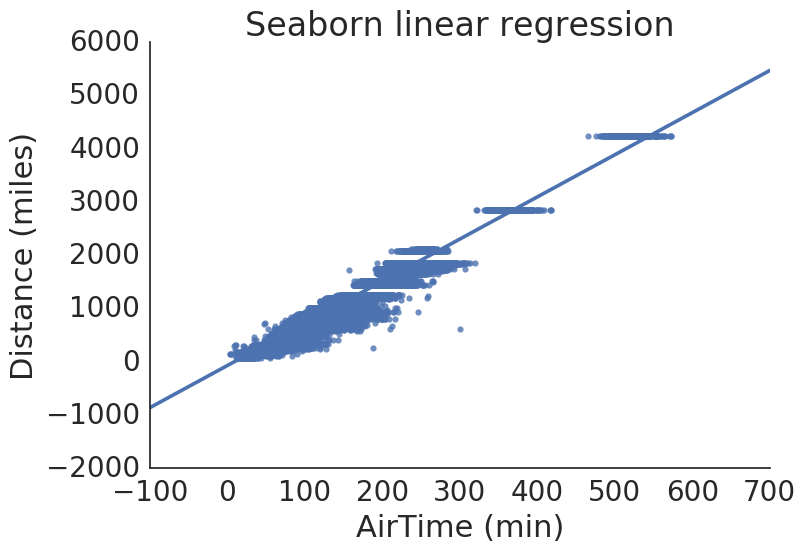

In [5]:
ax1 = plot_seaborn_reg(local)

In the following code cell, you will see some assert statements, and almost every assignment will have such tests. If you didn't take the Fall 2016 version of our course, these are what are called [unit tests](https://en.wikipedia.org/wiki/Unit_testing). When you submit completed assignments, instructors will determine your assignment grades by using automated grading tools to perform unit testing on your code, so if you pass all the tests without an error, you get a perfect score.

Writing the tests first, and *then* writing the actual code is actually a perfectly valid approach (preferred by many) to programming. It's called [test-driven development](https://en.wikipedia.org/wiki/Test-driven_development). So, you should learn what [assert](https://wiki.python.org/moin/UsingAssertionsEffectively) means in Python, and study [nose](http://nose.readthedocs.org/en/latest/testing.html). We will also use [Numpy testing tools](http://docs.scipy.org/doc/numpy/reference/routines.testing.html) to test arrays and [Pandas testing](http://pandas.pydata.org/developers.html#testing) to test pandas.Series and DataFrame objects.

In [6]:
assert_equal(isinstance(ax1, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax1.lines), 1)
assert_equal(len(ax1.collections), 2, msg="Your plot doesn't have a regression line.")

assert_is_not(len(ax1.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax1.xaxis.get_label_text(), "AirTime", msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax1.yaxis.get_label_text(), "Distance", msg="Change the y-axis label to something more descriptive.")
    
x, y = ax1.collections[0].get_offsets().T
assert_array_equal(x, local["AirTime"])
assert_array_equal(y, local["Distance"])

## Split a DataFrame into a testing and a test set

Now, we will include another predictor variable `ArrDelay` in the regression model in addition to `AirTime`. At the same time, we will split our data set into a training set and a test. We will use only the training set to learn a multivariate regresion model, predict `Distance` in the test set, and compare the predictions with the truth values in the test set.


For reproducibility, we have to pass an instance of [check_random_state()](http://scikit-learn.org/stable/modules/generated/sklearn.utils.check_random_state.html) to the `train_test_split()` function.

In [7]:
def get_train_test(df, train_columns, test_columns, test_size, random_state):
    '''
    Uses sklearn.train_test_split to split "df" into a testing set and a test set.
    The "train_columns" parameter lists the attributes that will be used for training.
    The "test_columns" lists the column that we are trying to predict.
    The "test_size" should be between 0.0 and 1.0 and represents the proportion of the
    dataset to include in the test split.
    The "random_state" parameter is used in sklearn.train_test.split.
    
    Parameters
    ----------
    train_columns: A list of strings
    test_columns: A list of strings
    test_size: A float
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    A 4-tuple of 
    '''
    #####################
    X = pd.DataFrame(data = df, columns = train_columns)
    Y = pd.DataFrame(data = df, columns = test_columns)
    
    # Cross-validation
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,
                                                       random_state = random_state)
    #####################

    return X_train, X_test, y_train, y_test

We use 80% of data for training and 20% for testing. We also seed the random number generator with number 0. Without the seed, the testing and test sets will be different every time you run the function.

In [8]:
X_train, X_test, y_train, y_test = get_train_test(
    df=local,
    train_columns=['AirTime', 'ArrDelay'],
    test_columns=['Distance'],
    test_size=0.2,
    random_state=check_random_state(0)
)

Make sure that your function passes the following tests.

In [9]:
assert_equal(len(X_train), np.round(len(local) * 0.8))
assert_frame_equal(
    X_train.iloc[:5, :],
    pd.DataFrame(
        index=[455345,  912717, 2456409, 1431043,  721122],
        data={'AirTime': [ 125., 44., 98., 225., 247.], 'ArrDelay': [56., -24., 31., -9., -2.]}
    )
)

assert_equal(len(X_test), np.round(len(local) * 0.2))
assert_frame_equal(
    X_test.iloc[:5, :],
    pd.DataFrame(
        index=[3639407, 1220091, 2772255, 5715261, 1979336],
        data={'AirTime': [98., 224., 231., 230., 81.], 'ArrDelay': [ 14., -22.,  -8.,   0.,   7.]}
    )
)

assert_equal(len(y_train), np.round(len(local) * 0.8))
assert_frame_equal(
    y_train.iloc[:5, :],
    pd.DataFrame(
        index=[455345, 912717, 2456409, 1431043, 721122],
        data={'Distance': [ 802,  235,  733, 1745, 1721]}
    )
)

assert_equal(len(y_test), np.round(len(local) * 0.2))
assert_frame_equal(
    y_test.iloc[:5, :],
    pd.DataFrame(
        index=[3639407, 1220091, 2772255, 5715261, 1979336],
        data={'Distance': [606, 1781, 1846, 1721, 594]}
    )
)

## Multiple independent variables

Now, we will use `ArrDelay` in addition to `AirTime` to predict `Distance`. In other words, we now have two independent variables `AirTime` and `ArrDelay`, and the dependent variable is `Distance`.

- Write a function named `get_statsmodels_reg()` that uses patsy formula in statsmodels on `AirTime`, `ArrDelay`, and `Distance`.

In [10]:
def get_statsmodels_reg(df_fit, X_predict):
    '''
    Trains OLS on the columns in "df_fit" and makes a prediction for "X_predict".
    Returns the predicted `DepDelay` values.
    
    Parameters
    ----------
    df_fit: A pandas.DataFrame. Should have "AirTime", "ArrDelay", and "Distance" columns.
    X_predict: A pandas.DataFrame. Should have "AirTime" and "ArrDelay" columns.
    
    Returns
    -------
    A numpy array
    '''
    #####################
    # Fit a multiple linear model
    result = smf.ols(formula='Distance ~ AirTime + ArrDelay', data=df_fit).fit()
    
    # Make the prediction
    y_predict = result.predict(X_predict)
    #####################

    return y_predict

Since `get_statsmodels_reg()` accepts a DataFrame with three columns, but two of the columns are in `X_train` while the remaning one is in `y_train`. We combine the columns to create a new DataFrame that we will use for the `df_train` parameter. We will also make predictions on 10 points equally spaced from the minimum and the maximum of each variable.

In [11]:
df_train = pd.DataFrame({
    "AirTime": X_train["AirTime"].values,
    "ArrDelay": X_train["ArrDelay"].values,
    "Distance": y_train["Distance"].values})

X_pred = pd.DataFrame({
    'AirTime': np.linspace(X_test['AirTime'].min(), X_test['AirTime'].max(), 10),
    'ArrDelay': np.linspace(X_test['ArrDelay'].min(), X_test['ArrDelay'].max(), 10)
    })

y_pred = get_statsmodels_reg(df_train, X_pred)

The following test compares the predicted values to the values I recieved. Since statsmodels.ols is deterministic, your answer should be the same as mine.

In [11]:
assert_array_almost_equal(
    y_pred,
    np.array([  -10.24755291,   432.77802136,   875.80359563,  1318.8291699 ,
        1761.85474417,  2204.88031843,  2647.9058927 ,  3090.93146697,
        3533.95704124,  3976.9826155 ])
    )

## Plot the multivariate regression model

Finally, plot the model we trained with `get_statsmodels_reg()`. Your plot should have both the scatter plot of `Distance` vs. `AirTime` and the line of the multivariate regression model.

Note that the `plot_statsmodels_reg()` returns a `matplotlib.Axes` object.

In [13]:
%matplotlib inline
def plot_statsmodels_reg(df_test, df_pred):
    '''
    Plots the follwoing:
    1. A scatter plot of the "AirTime" column of "df_test" on the x-axis
       and the "Distance" column of "df_test" on the y-axis,
    2. A straight line (multivariate linear regression model) of the
       "AirTime" column of "df_pred" on the x-axis and the "Distance"
       column of "df_pred" on the y-axis.
              
    Parameters
    ----------
    df_test: A pandas.DataFrame
    df_pred: A pandas.DataFrame
    
    Returns
    -------
    A matplotlib.Axes object
    '''
    #####################
    # scatter plot
    ax = sns.regplot('AirTime', 'Distance', df_test, fit_reg=False, label='Data',color = 'dodgerblue')

    plt.plot(df_pred['AirTime'], df_pred['Distance'], sns.xkcd_rgb["pale red"], lw=3, label='Fit')

    ax.set(title='StatsModels Regression',
       xlabel='Air Time (minutes)', xlim=(-100, 600),
       ylabel='Distance (miles)', ylim=(-1000, 5000))
    
    ax.legend(loc=4)
    sns.despine(offset=0, trim=True)
    #####################

    return ax

Here's an example. The blue points are points in the test data, and the red line is the regression model predicted by statsmodels.

![](images/statsmodels_ols.png)

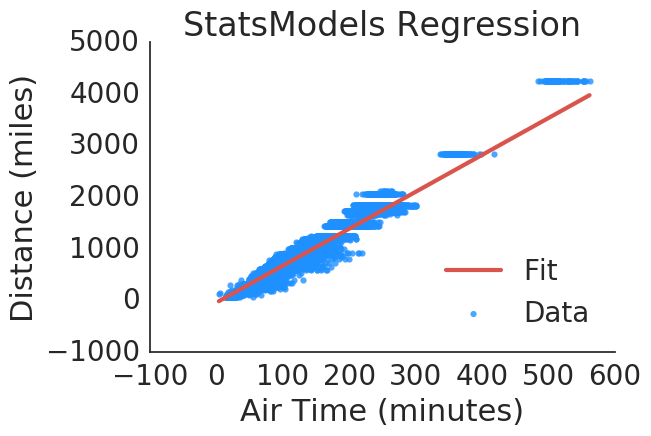

In [14]:
df_test = pd.DataFrame({
    'AirTime': X_test['AirTime'].values,
    'Distance': y_test['Distance'].values
    })

df_pred = pd.DataFrame({
    'AirTime': X_pred['AirTime'].values,
    'Distance': y_pred
    })

ax2 = plot_statsmodels_reg(df_test, df_pred)

Make sure that your function passes the following tests.

In [15]:
assert_equal(isinstance(ax2, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax2.lines), 1)
assert_equal(len(ax2.collections), 1, msg="You should turn off Seaborn regression.")

assert_is_not(len(ax2.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax2.xaxis.get_label_text(), "AirTime", msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax2.yaxis.get_label_text(), "Distance", msg="Change the y-axis label to something more descriptive.")
    
x_scatter, y_scatter = ax2.collections[0].get_offsets().T
assert_array_equal(x_scatter, df_test["AirTime"])
assert_array_equal(y_scatter, df_test["Distance"])

line = ax2.get_lines()[0]
x_line = line.get_xdata()
y_line = line.get_ydata()
assert_array_equal(x_line, df_pred["AirTime"])
assert_array_almost_equal(y_line, y_pred)